### based on https://huggingface.co/docs/transformers/en/tasks/image_classification

In [1]:
!pip install transformers datasets evaluate

# Load Food-101 dataset

In [2]:
from datasets import load_dataset

# limit dataset size to decrease training time during the workshop
food = load_dataset("food101", split="train[:2500]")

In [3]:
food = food.train_test_split(test_size=0.2)

In [4]:
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 53}

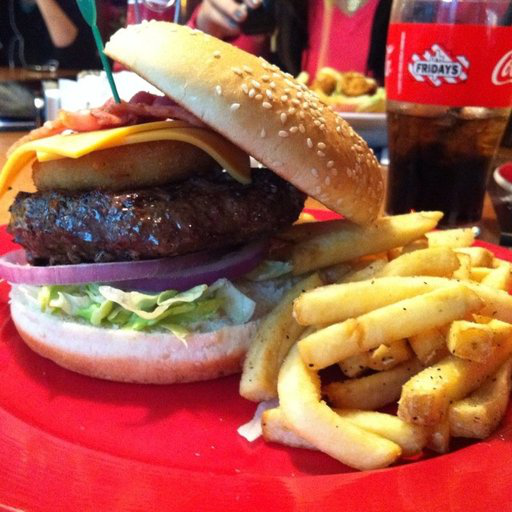

In [5]:
food["train"][0]["image"]

In [6]:
# create a dictionary that maps the label name to an integer and vice versa
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [7]:
id2label[str(food["train"][0]["label"])]

'hamburger'

# Preprocess

In [8]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [9]:
!pip install matplotlib

In [10]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

### Data augmentation

In [11]:
# see https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html
from torchvision.transforms.v2 import RandomAffine, RandomPerspective, RandomResizedCrop, ColorJitter, RandAugment, RandomHorizontalFlip

orig_img = food["train"][0]["image"]

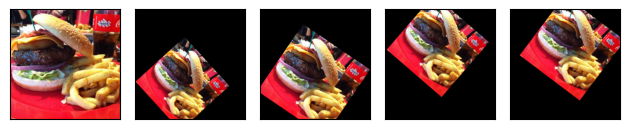

In [12]:
affine_transfomer = RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_imgs = [affine_transfomer(orig_img) for _ in range(4)]
plot([orig_img] + affine_imgs)

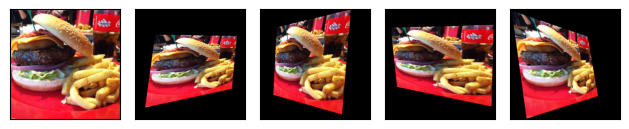

In [13]:
perspective_transformer = RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot([orig_img] + perspective_imgs)

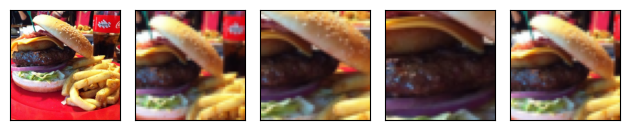

In [14]:
resize_cropper = RandomResizedCrop(size=(50, 50))
resized_crops = [resize_cropper(orig_img) for _ in range(4)]
plot([orig_img] + resized_crops)

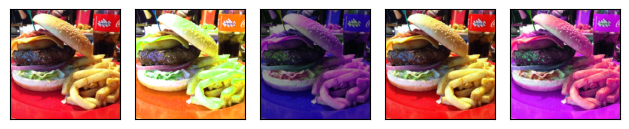

In [15]:
jitter = ColorJitter(brightness=.5, hue=.3)
jittered_imgs = [jitter(orig_img) for _ in range(4)]
plot([orig_img] + jittered_imgs)

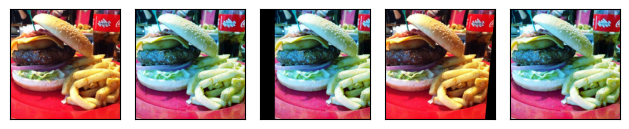

In [16]:
augmenter = RandAugment()
imgs = [augmenter(orig_img) for _ in range(4)]
plot([orig_img] + imgs)

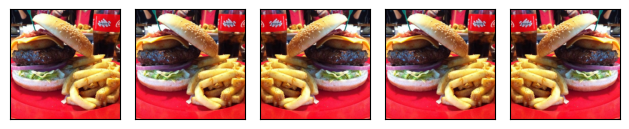

In [17]:
hflipper = RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(orig_img) for _ in range(4)]
plot([orig_img] + transformed_imgs)

In [18]:
# apply data augmentation to prevent overfitting
from torchvision.transforms.v2 import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, RandomHorizontalFlip

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), RandomHorizontalFlip(), ToTensor(), normalize])

_transforms_inference = Compose([Resize(size), ToTensor(), normalize])

/home/alex/miniconda3/envs/pytorch_cuda_11.8/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [19]:
# apply transforms and return pixel values
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

def transforms_inference(examples):
    examples["pixel_values"] = [_transforms_inference(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [20]:
food = food.with_transform(transforms)

In [21]:
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 500
    })
})

In [22]:
# create a batch of examples
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# Evaluate

In [23]:
!pip install scikit-learn

In [24]:
import evaluate

accuracy = evaluate.load("accuracy")

In [25]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Train

In [26]:
# Load ViT model with specified number of classes
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# set training parameters
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

/home/alex/miniconda3/envs/pytorch_cuda_11.8/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [28]:
trainer.train()

/home/alex/miniconda3/envs/pytorch_cuda_11.8/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1711403463728/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch,Training Loss,Validation Loss,Accuracy
0,3.106000,2.775994,0.872000
1,2.224000,2.058665,0.904000
2,1.918400,1.892421,0.910000


TrainOutput(global_step=93, training_loss=2.7033158322816253, metrics={'train_runtime': 358.5056, 'train_samples_per_second': 16.736, 'train_steps_per_second': 0.259, 'total_flos': 4.616415762481152e+17, 'train_loss': 2.7033158322816253, 'epoch': 2.98})

# Inference

In [29]:
ds = load_dataset("food101", split="validation[:10]")

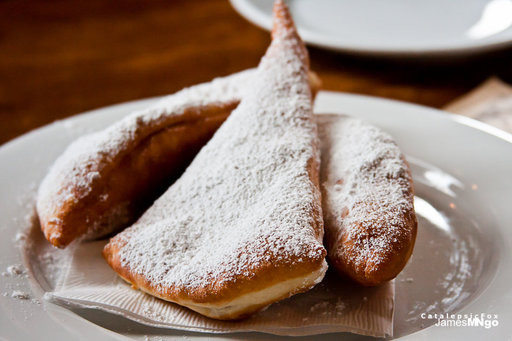

In [30]:
ds["image"][9]

In [31]:
id2label[str(ds["label"][9])]

'beignets'

In [32]:
ds_processed = ds.with_transform(transforms_inference)

In [33]:
inference_result = trainer.predict(ds_processed)

In [34]:
inference_result

PredictionOutput(predictions=array([[-0.19088186, -0.28075463, -0.26590148, ..., -0.19690311,
        -0.04504542, -0.1652513 ],
       [-0.39509943, -0.3742286 , -0.2798826 , ..., -0.21729934,
        -0.19070178, -0.29287365],
       [-0.18055625, -0.25951838, -0.3450363 , ..., -0.2653435 ,
        -0.10307458, -0.15013053],
       ...,
       [-0.1746188 , -0.21588007, -0.3485448 , ..., -0.15429778,
        -0.03982768, -0.10703915],
       [-0.49989986, -0.3872288 , -0.1535442 , ..., -0.22889432,
        -0.26066586, -0.32436815],
       [-0.19197597, -0.20581418, -0.33703393, ..., -0.15504596,
        -0.05753052, -0.09274212]], dtype=float32), label_ids=array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6]), metrics={'test_loss': 1.765599012374878, 'test_accuracy': 0.9, 'test_runtime': 0.2765, 'test_samples_per_second': 36.168, 'test_steps_per_second': 3.617})

In [35]:
for i, logits in enumerate(inference_result.predictions):
    predicted_id = np.argmax(logits)
    print(f"predicted: {predicted_id} ({id2label[str(predicted_id)]}); ground_truth: {inference_result.label_ids[i]}")
    

predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 79 (prime_rib); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6


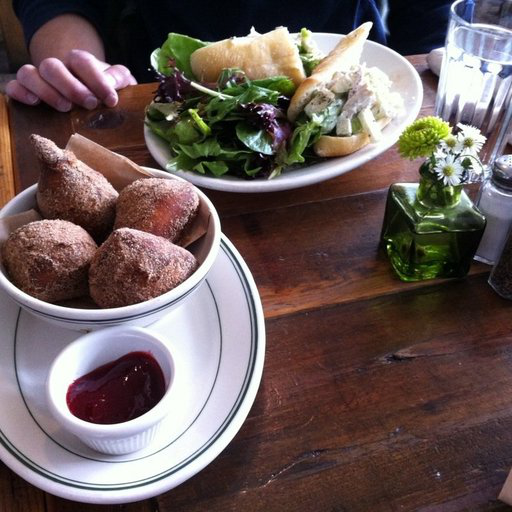

In [36]:
ds["image"][-2]